Nama:

In [1]:
print('Rahman Aziz Firmansyah')

Rahman Aziz Firmansyah


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, OneHotEncoder, PolynomialFeatures
from sklearn.feature_selection import mutual_info_classif, SelectKBest, VarianceThreshold
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, precision_recall_curve, roc_auc_score, roc_curve, r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBRegressor
from sklearn.cluster import KMeans
import sklearn.tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from scipy.stats import spearmanr
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

(1) Import dataset spam sms. Jadikan kolom 'v1' menjadi kolom target, dengan ham = 0 (non-spam), spam = 1.

In [3]:
sms = pd.DataFrame(pd.read_csv('sms_spam_new.csv'))
sms.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
#mengubah value di kolom v1 menjadi 0 dan 1
sms['v1'] = np.where(sms['v1'] == 'spam', 1, 0)
sms.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


(2) Periksa adanya missing value pada dataset, dan lakukan dropna apabila sedikit jumlahnya.

In [5]:
sms.isna().sum()

v1    0
v2    0
dtype: int64

In [6]:
#memisahkan fitur input dan target
X = sms['v2']
y = sms['v1']

(3) Lakukan train test split, test:test = 4:1, stratify = y.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

(4) Buat 2 model (dalam bentuk pipeline): countvectorizer + multinomialnb default dan optimized. Lakukan cross-validation dengan pipeline dengan step: countvectorizer dan multinomialnb untuk menentukan nilai optimal untuk hyperparameter max_df dan max_features untuk countvectorizer; serta class_prior untuk multinomialnb. 

In [8]:
#pipeline default
pipline_def = make_pipeline(CountVectorizer(), MultinomialNB())
pipline_def.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB())])

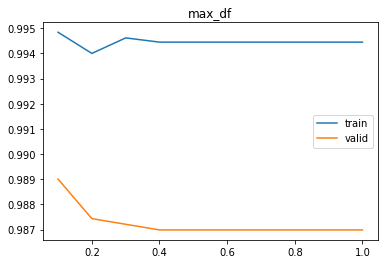

0.1

In [9]:
#optimasi hyperparameter untuk model-model dalam pipeline
params = np.arange(0.1, 1.1, 0.1)
train = []
valid = []

for par in params:
    pl_opt = make_pipeline(CountVectorizer(max_df=par), MultinomialNB())
    result = cross_validate(pl_opt, X_train, y_train, cv=5, return_train_score=True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())

sns.lineplot(x = params, y = train, label = 'train')
sns.lineplot( x = params, y = valid, label = 'valid')
plt.title('max_df')
plt.show()
max_df_fin = params[np.argmax(valid)]
max_df_fin

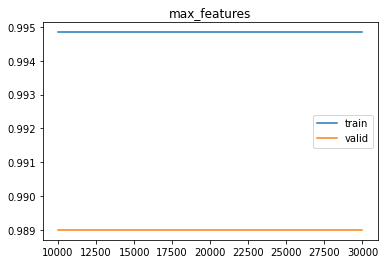

10000

In [10]:
#optimasi hyperparameter untuk model-model dalam pipeline
params = [10000, 20000, 30000]
train = []
valid = []

for par in params:
    pl_opt = make_pipeline(CountVectorizer(max_df=max_df_fin, max_features=par), MultinomialNB())
    result = cross_validate(pl_opt, X_train, y_train, cv=5, return_train_score=True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())

sns.lineplot(x = params, y = train, label = 'train')
sns.lineplot( x = params, y = valid, label = 'valid')
plt.title('max_features')
plt.show()
max_ft_fin = params[np.argmax(valid)]
max_ft_fin

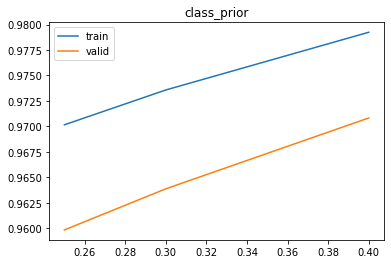

0.4

In [11]:
#optimasi hyperparameter untuk model-model dalam pipeline
params = [0.25, 0.3, 0.4]
train = []
valid = []

for par in params:
    pl_opt = make_pipeline(CountVectorizer(max_df=max_df_fin, max_features=max_ft_fin), MultinomialNB(class_prior=[par, 1-par]))
    result = cross_validate(pl_opt, X_train, y_train, cv=5, return_train_score=True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())

sns.lineplot(x = params, y = train, label = 'train')
sns.lineplot( x = params, y = valid, label = 'valid')
plt.title('class_prior')
plt.show()
cp_fin = params[np.argmax(valid)]
cp_fin

In [13]:
pipeline_fin = make_pipeline(CountVectorizer(max_df=max_df_fin, max_features=max_ft_fin), 
MultinomialNB(class_prior=[cp_fin, 1-cp_fin]))
pipeline_fin.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.1, max_features=10000)),
                ('multinomialnb', MultinomialNB(class_prior=[0.4, 0.6]))])

(5) Print classification report untuk trainset dan testset (default vs optimized). Apakah optimisasi meningkatkan performansi dari model?

In [14]:
#model default untuk training dan testing set
import classification
classification.classif(X_train, y_train, pipline_def)
classification.classif(X_test, y_test, pipline_def)

              precision    recall  f1-score   support

           1       0.98      0.97      0.98       598
           0       1.00      1.00      1.00      3859

    accuracy                           0.99      4457
   macro avg       0.99      0.98      0.99      4457
weighted avg       0.99      0.99      0.99      4457

              precision    recall  f1-score   support

           1       0.96      0.91      0.94       149
           0       0.99      0.99      0.99       966

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [15]:
#model yang telah dioptimasi
classification.classif(X_train, y_train, pipeline_fin)
classification.classif(X_test, y_test, pipeline_fin)

              precision    recall  f1-score   support

           1       0.88      0.98      0.93       598
           0       1.00      0.98      0.99      3859

    accuracy                           0.98      4457
   macro avg       0.94      0.98      0.96      4457
weighted avg       0.98      0.98      0.98      4457

              precision    recall  f1-score   support

           1       0.85      0.94      0.89       149
           0       0.99      0.97      0.98       966

    accuracy                           0.97      1115
   macro avg       0.92      0.96      0.94      1115
weighted avg       0.97      0.97      0.97      1115



Berdasarkan nilai precision dan recall kedua model, optimasi tidak meningkatkan performa pipeline. Performa model default lebih baik dibandingkan model yang telah dioptimasi